# **Newcastle Cradlewell- Using Machine learning to assess the impact of 'clean air' interventions on Nitrogen Dioxide (NO₂)**



**DESCRIPTION:**

This project aims to show the impact of an intervention (such as a Clean Air Zone) on NO₂ by building a Random Forest machine learning model. The model is trained on data prior to the introduction of the intervention- using meteorological variables such as wind speed, wind direction, and temperature, along with time-based features.

The trained model is then used to predict NO₂ concentrations for after the intervention is introduced to extract NO₂ concentrations as if there had been no intervention introduced. These counterfactual predictions are compared with actual observed values during the intervention period to estimate the change in pollutant levels attributable to the intervention. COVID-19 periods, during which traffic and pollution levels dropped significantly, is disregarded for model training inline literature on the topic.

This approach is taken for NO₂ analyses as NO₂ concentrations are greatly affected by meteorological variables. This makes NO₂ analysis hard as changes in concentrations are often hidden by meteorological factors. The machine learning model essentially takes out the influence of meteorological variables and makes impacts of interventions easy to analyse.

This workbook is based off work from my University dissertation project "Using machine learning to assess the impact of Newcastle and Sheffield’s Clean Air Zones on Nitrogen dioxide". This workbook has been adapted from the dissertation so that any intervention on NO₂ can be investigated as long as there is enough DEFRA data available for the site

**OBJECTIVES:**

- Develop a regression-based time series model to predict NO₂ levels using weather and temporal features.
- Generate counterfactual pollutant predictions for the post intervention period.
- Quantify and visualise the estimated impact of the intervention by comparing predicted (no-intervention) vs actual (with-intervention) values.

# Setup

In [ ]:
from astropy.time import Time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as stats
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
from google.colab import drive

drive.mount('/content/drive') # Mount Drive

Mounted at /content/drive


# Config

In [ ]:
Site = 'Newcastle Cradlewell'
Extra_site_info = '(Outside CAZ)' # Optional
Start_date = pd.to_datetime('30-01-2023', dayfirst=True) # Intervention Start
Intervention_type = 'CAZ' # Intervention Type
COVID_start = pd.to_datetime('16-03-2020', dayfirst=True)
COVID_end =  pd.to_datetime('01-03-2022', dayfirst=True)

# **Load Data**
- DEFRA data is available to download here(https://uk-air.defra.gov.uk/data/data_selector)
- When downloading data from the DEFRA data there is a 5 year limit for downloaded data- section below loads the raw data from DEFRA and combines them into one df

##**Steps to download data:**

- DEFRA website (https://uk-air.defra.gov.uk/data/data_selector)
- Select: Serach Hourly Networks

Select Data Type- 'Measured Data'

Select date Range- 'Custom Date (below)'- indvuial choice (it is best to try get as much data as possible to train the model- select dates where metelogical data is availe- aim for ast least 6 years of training data (data before the intervention) inline with literature. As mentioned above, data is only available in 5 year increments)   

Select Monitoring Sites- 'Local Authority'- select the area of interest- then individual site

Select Pollutants- 'Pollutant Name'- 'Select All'

Select Output Type- 'Data to Email Address (CSV)' - enter email and Agree Terms

'Get Data'

In [ ]:
# 2010-2015
df_10to15 = pd.read_csv(
    '/content/drive/My Drive/Colab Notebooks/cleanup_dis_code/data/TEST/NCL_crad_10_15.csv',
    skiprows=10, skipfooter=1, engine="python")

# 2015-2020
df_15to20 = pd.read_csv(
    '/content/drive/My Drive/Colab Notebooks/cleanup_dis_code/data/TEST/NCL_crad_15_20.csv',
    skiprows=10, skipfooter=1, engine="python")

# 2020-2025
df_20to25 = pd.read_csv(
    '/content/drive/My Drive/Colab Notebooks/cleanup_dis_code/data/TEST/NCL_crad_20_25.csv'
    , skiprows=10, skipfooter=1, engine="python")

# combine into one
df = pd.concat([df_10to15, df_15to20, df_20to25])

##Process

In [ ]:
# change 'No data' to nan
df.replace('No data', np.nan, inplace=True)

# format date
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Rename columns for simplicity
df = df.rename(columns={'Modelled Temperature': 'Temp',
                                          'Modelled Wind Speed': 'WindSpeed',
                                          'Modelled Wind Direction': 'WindDir',
                                          'Nitrogen dioxide':'NO2'})

In [ ]:
# extract relevant columns
df= df[
    ['Date','Time','NO2', 'WindDir', 'WindSpeed', 'Temp']]
df.head()

Date      Time NO2 WindDir WindSpeed  Temp
0 2010-08-01  01:00:00  53   266.9       5.6  11.5
1 2010-08-01  02:00:00  32   269.8       5.6  11.5
2 2010-08-01  03:00:00  21   275.4       5.6  11.4
3 2010-08-01  04:00:00  11   280.7       5.5  11.4
4 2010-08-01  05:00:00   8   282.4       5.3  11.6

# **Data Summary**

In [ ]:
df.shape
# Hourly data approx 15 years

(126432, 6)

In [ ]:
df.head()

Date      Time NO2 WindDir WindSpeed  Temp
0 2010-08-01  01:00:00  53   266.9       5.6  11.5
1 2010-08-01  02:00:00  32   269.8       5.6  11.5
2 2010-08-01  03:00:00  21   275.4       5.6  11.4
3 2010-08-01  04:00:00  11   280.7       5.5  11.4
4 2010-08-01  05:00:00   8   282.4       5.3  11.6

In [ ]:
df.tail()

Date      Time       NO2 WindDir WindSpeed Temp
43843 2025-01-01  20:00:00  11.87671   323.1         5  1.7
43844 2025-01-01  21:00:00   8.06658   327.6       4.9  1.4
43845 2025-01-01  22:00:00   7.19948   327.5       4.4  1.4
43846 2025-01-01  23:00:00   6.40634   317.9       3.7  1.1
43847 2025-01-01  24:00:00   5.56984     326       4.4  1.1

# **Missing data**

## Exploratory Analysis of Missing Data

In [ ]:
# Missing data summary
missing_data = df.isnull().sum()
print(missing_data)

Date             0
Time             0
NO2          13348
WindDir       3213
WindSpeed     3213
Temp          3213
dtype: int64


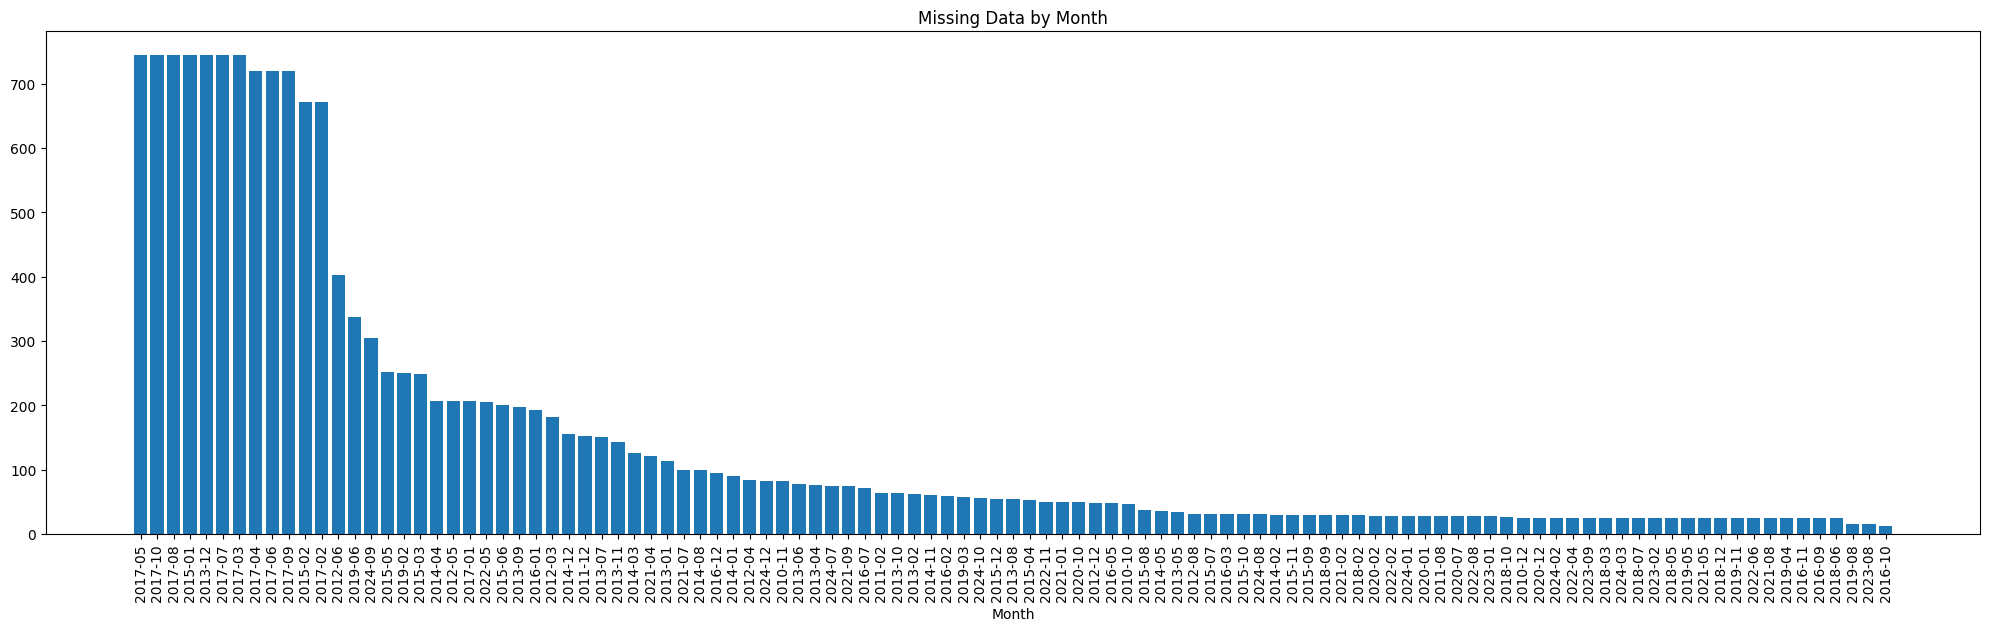

In [ ]:
# Which months have most missing data?
missing_data_months = (
    df[df.isnull().any(axis=1)]['Date'].dt.to_period('M').value_counts())

# Filter to have more than 10 missing
missing_data_month = missing_data_months[missing_data_months > 10]

# Plot
plt.figure(figsize=(20, 6))
plt.bar(missing_data_month.index.astype(str), missing_data_month.values)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Missing Data by Month')
plt.xlabel('Month')
plt.show()

A month of 30 days has ~720 data points- some months have no data

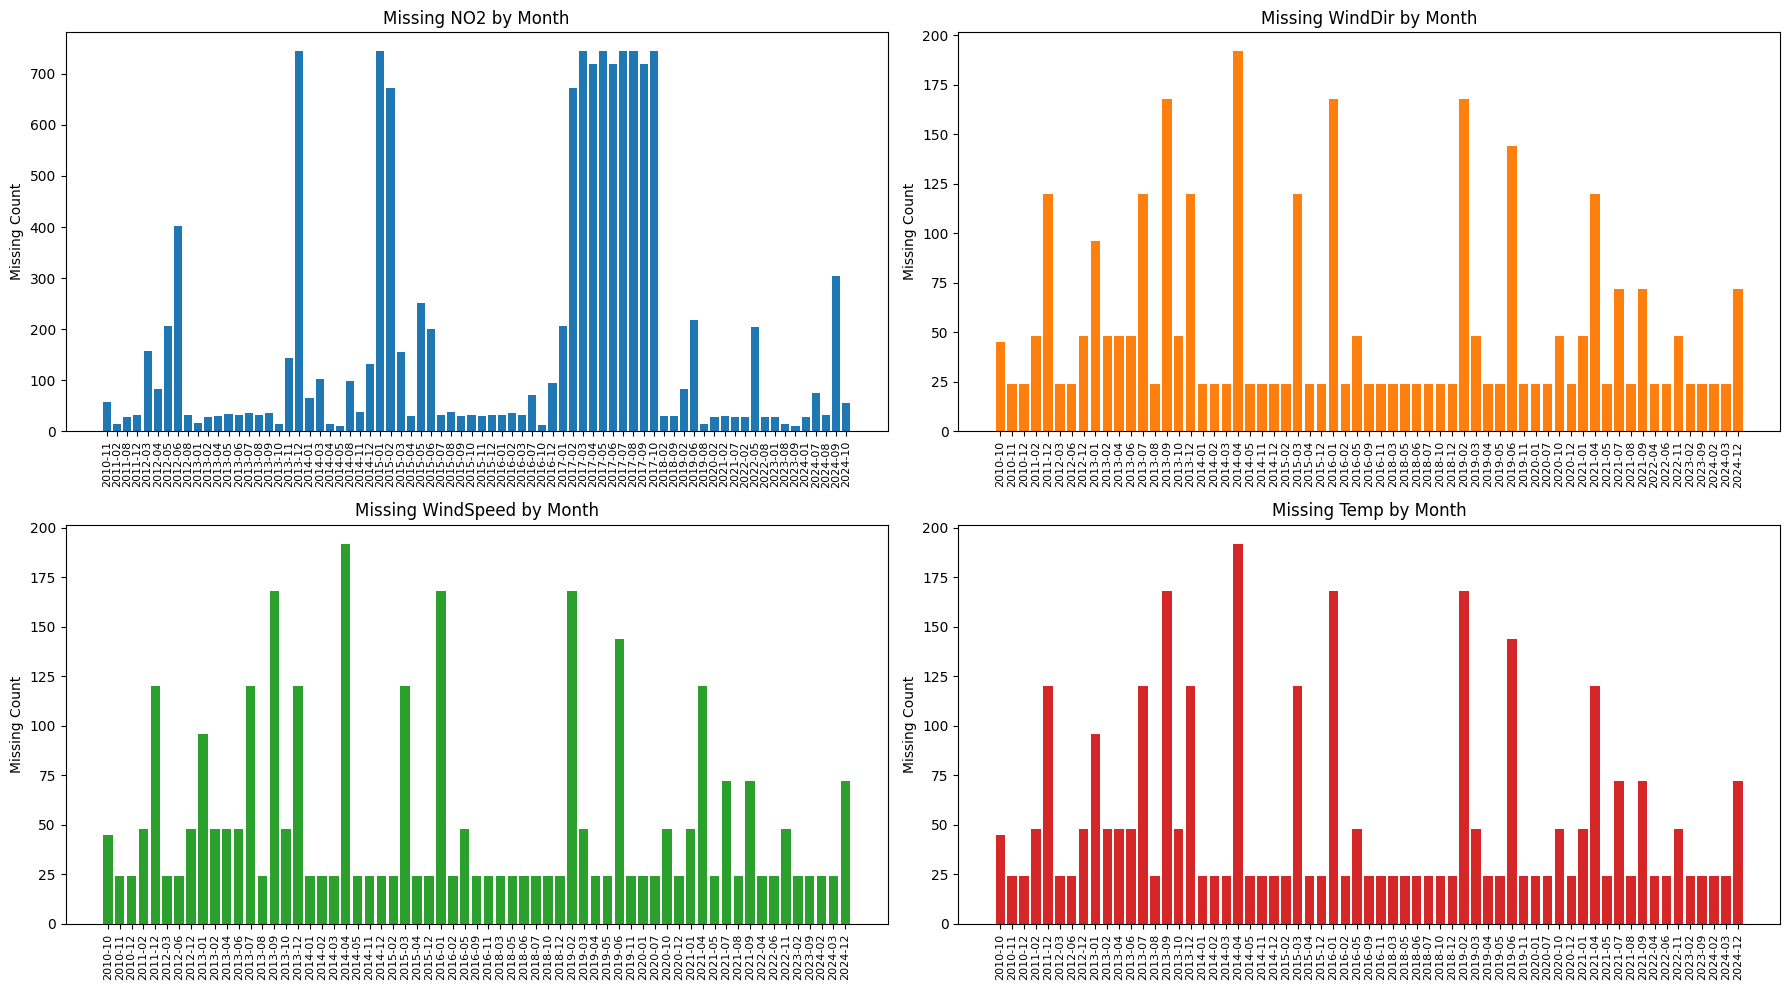

In [ ]:
# Which months have most missing data in each key variable?

variables = ['NO2', 'WindDir', 'WindSpeed', 'Temp']
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, axes = plt.subplots(2,2, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(variables):

    missing_data_months = (
        df[df[var].isnull()]['Date'].dt.to_period('M').value_counts())
    missing_data_months = (
        missing_data_months[missing_data_months > 10].sort_index())
     # Remove sort_index() to order by values

    ax = axes[i]
    x_labels = missing_data_months.index.astype(str)
    ax.bar(x_labels, missing_data_months.values, color=colours[i])
    ax.set_title(f"Missing {var} by Month")
    ax.set_ylabel("Missing Count")
    ax.tick_params(axis='x', rotation=90, labelsize=8)

plt.tight_layout()
plt.show()

## Impute Missing Data

- if available, missing meterolgocial data can instead be filled using local histricoal met data- such as HadUK-Grid dataset or MIDAS-Open - (https://www.metoffice.gov.uk/research/climate/maps-and-data/data/index)

In [ ]:
# create a colloum for month and hour
df['Month'] = df['Date'].dt.month
df['Hour'] = df['Time'].str[0:2].astype(int)

In [ ]:
# NO2 and Temp- Impute nan using monthly/hourly median
for col in ['NO2', 'Temp','WindSpeed']:
  df[col] = pd.to_numeric(df[col], errors='coerce')
  df[col] = (
      df.groupby(['Month', 'Hour'])[col].transform(lambda x: x.fillna(x.median())))

In [ ]:
# Wind

df['WindDir'] = pd.to_numeric(df['WindDir'], errors='coerce')
df['WindSpeed'] = pd.to_numeric(df['WindSpeed'], errors='coerce')

radians = np.deg2rad(df['WindDir'])
df['WindDir_sin'] = np.sin(radians)
df['WindDir_cos'] = np.cos(radians)

# Set Date as index for time based interpolation
df = df.set_index('Date')

df['WindSpeed'] = df['WindSpeed'].interpolate(method='time')
df['WindDir_sin'] = df['WindDir_sin'].interpolate(method='time')
df['WindDir_cos'] = df['WindDir_cos'].interpolate(method='time')

# reset index
df = df.reset_index()

# Drop WindDir
df = df.drop(columns=['WindDir'])

# Exploratory Data Analysis


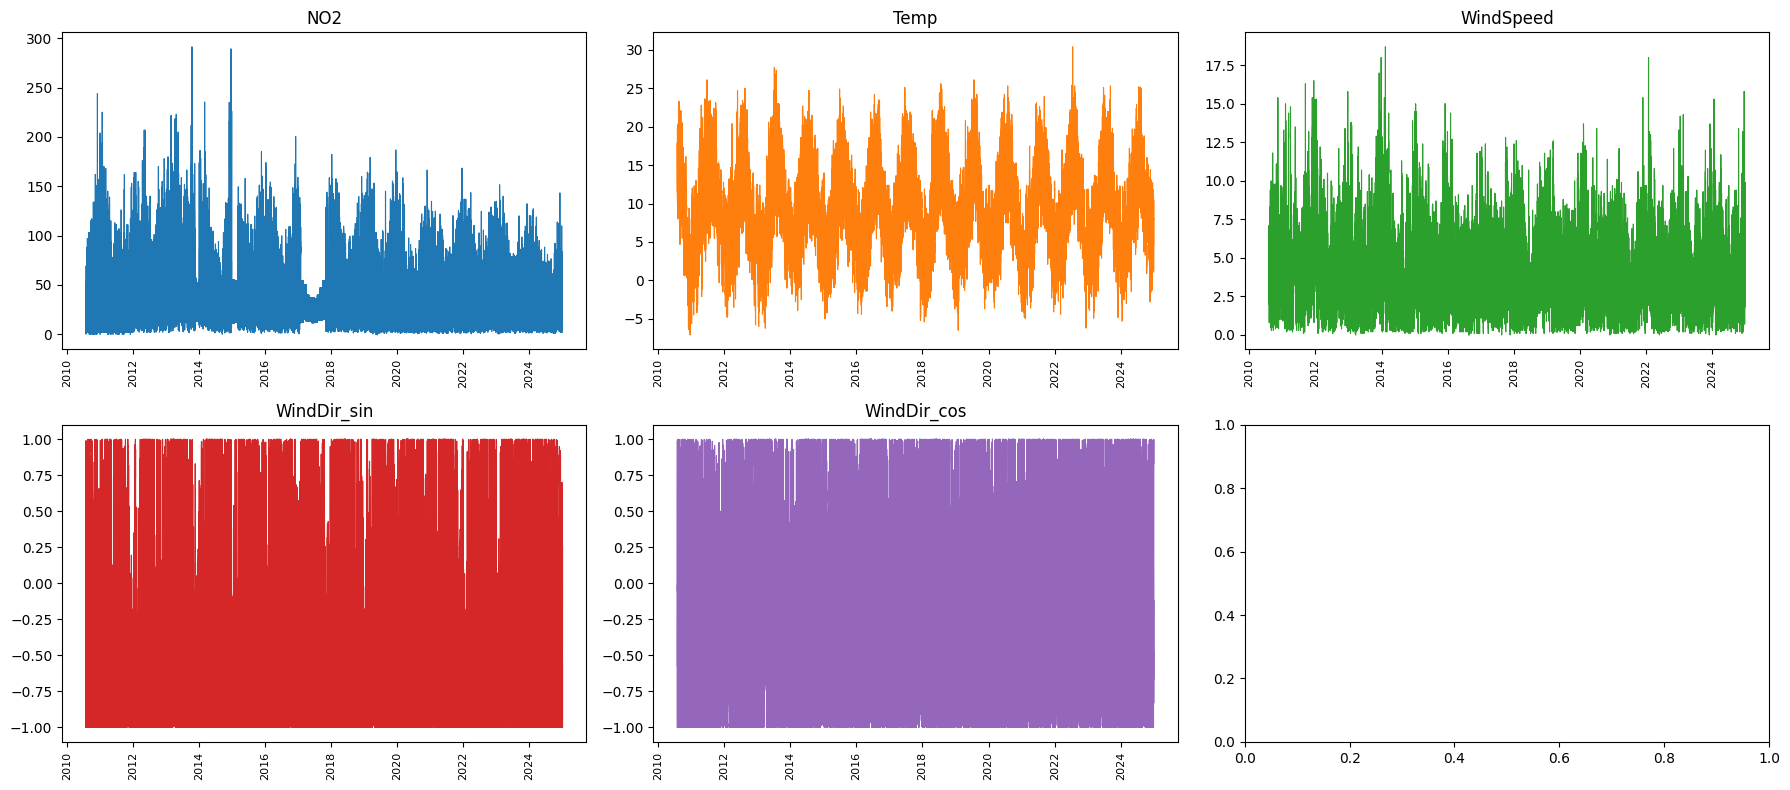

In [ ]:
variables = [ 'NO2', 'Temp', 'WindSpeed', 'WindDir_sin', 'WindDir_cos']
colour = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

fig, axes = plt.subplots(2,3, figsize=(18, 8))
axes = axes.flatten()

for i, var in enumerate(variables):

    ax = axes[i]
    x_labels = missing_data_months.index.astype(str)
    ax.plot(df['Date'], df[var], label=var, color=colours[i], linewidth=0.8)

    ax.set_title(f"{var}")
    ax.tick_params(axis='x', rotation=90, labelsize=8)

plt.tight_layout()
plt.show()

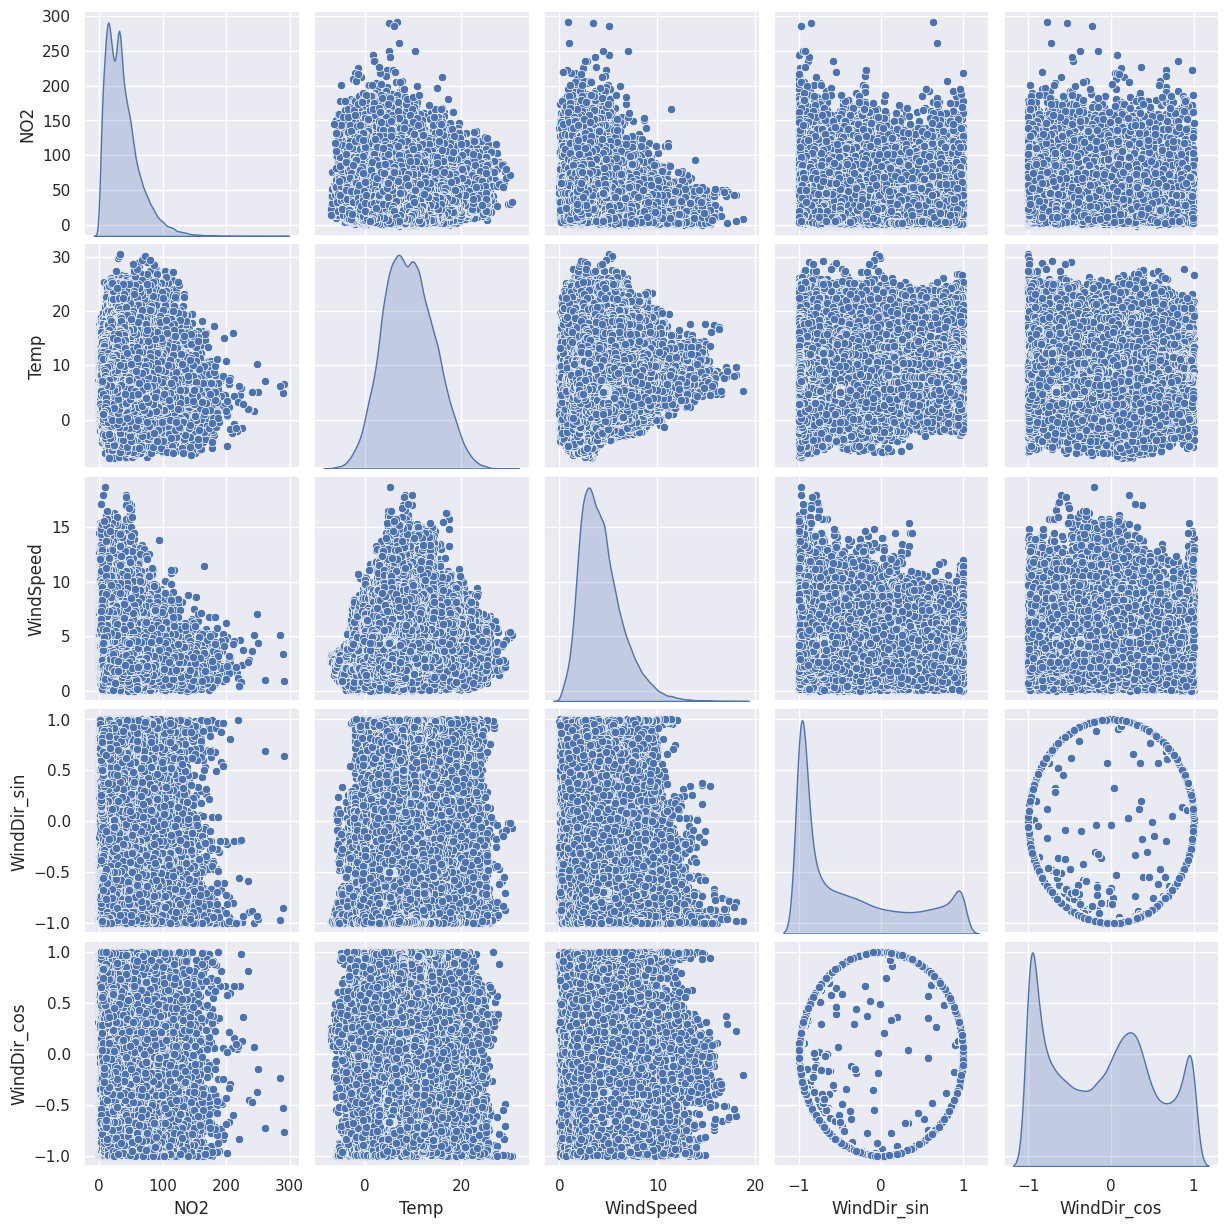

In [ ]:
# Pairplot
sns.set(rc={'figure.figsize':(10,8)})
sns.pairplot(df[[ 'NO2', 'Temp', 'WindSpeed', 'WindDir_sin', 'WindDir_cos']],
             diag_kind='kde')
plt.show()

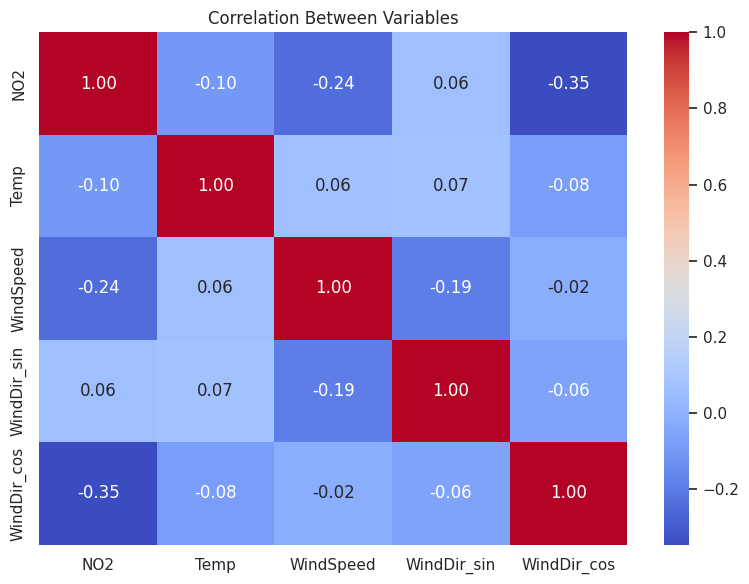

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[variables].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Variables")
plt.tight_layout()
plt.show()

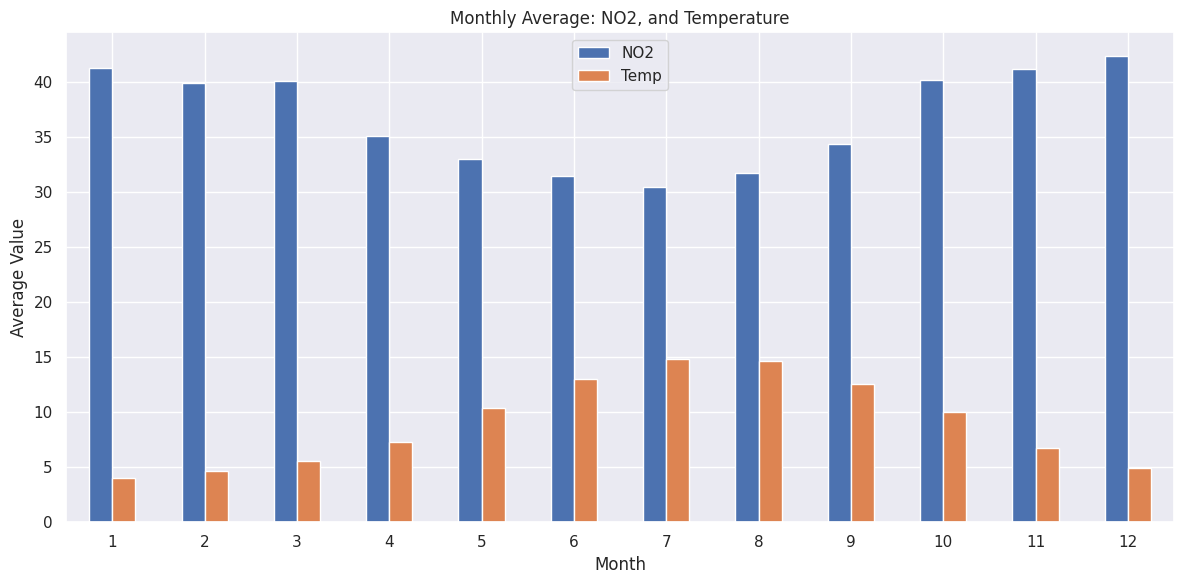

In [ ]:
monthly_avg = df.groupby('Month')[[ 'NO2', 'Temp']].mean()

monthly_avg.plot(kind='bar', figsize=(12, 6))
plt.title("Monthly Average: NO2, and Temperature")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


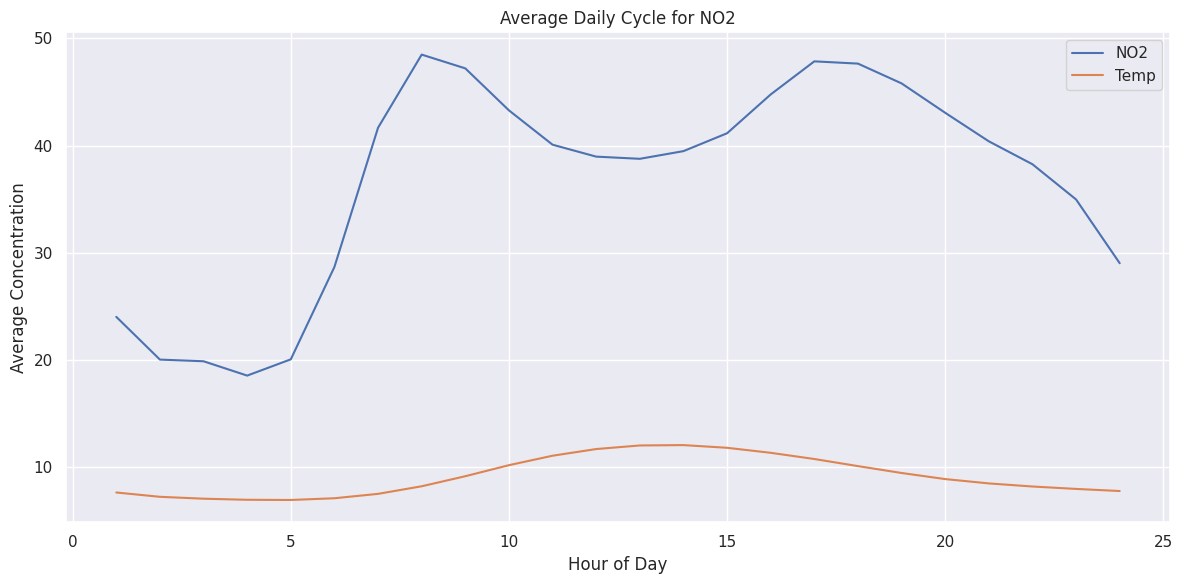

In [ ]:
hourly_avg = df.groupby('Hour')[[ 'NO2', 'Temp']].mean()

hourly_avg.plot(figsize=(12, 6))
plt.title("Average Daily Cycle for NO2")
plt.xlabel("Hour of Day")
plt.ylabel("Average Concentration")
plt.grid(True)
plt.tight_layout()
plt.show()


# Processing

## Extreme vaules/outliares
Note:
The Air Quality Standards Regulations (2010) require that the annual mean concentration of NO₂ must not exceed 40 µg/m3 and that there should be no more than 18 exceedances of the hourly mean limit value (concentrations above 200 µg/m3) in a single year.


High vaules >200

In [ ]:
Over200 = df[(df['NO2'] >=200)]
print(Over200)

            Date      Time        NO2  WindSpeed   Temp  Month  Hour  \
3057  2010-12-06  10:00:00  201.00000        4.9   0.60     12    10   
3058  2010-12-06  11:00:00  244.00000        5.1   1.60     12    11   
3776  2011-01-05  09:00:00  204.00000        2.8   2.30      1     9   
3825  2011-01-07  10:00:00  201.00000        1.4  -4.90      1    10   
4337  2011-01-28  18:00:00  212.00000        2.2  -0.80      1    18   
4338  2011-01-28  19:00:00  225.00000        2.4  -1.50      1    19   
4339  2011-01-28  20:00:00  218.00000        1.6  -2.10      1    20   
4340  2011-01-28  21:00:00  210.00000        1.8  -2.50      1    21   
15457 2012-05-06  02:00:00  207.00000        2.5  -1.80      5     2   
15751 2012-05-18  08:00:00  207.00000        3.1   7.70      5     8   
22602 2013-02-27  19:00:00  221.84761        4.7   4.50      2    19   
22603 2013-02-27  20:00:00  213.22510        4.6   4.35      2    20   
23622 2013-04-11  07:00:00  218.37260        1.2   3.20      4  

Identify NO₂ Spikes
- above 40 and 1.5* the vaule before and after

In [ ]:
spike = df[
    (df['NO2'] > 40) &
    (df['NO2'] >= 1.5 * df['NO2'].shift(1)) &
    (df['NO2'] >= 1.5* df['NO2'].shift(-1))
]
print(spike)

             Date      Time       NO2  WindSpeed  Temp  Month  Hour  \
473    2010-08-20  18:00:00  57.00000        6.8  20.1      8    18   
630    2010-08-27  07:00:00  78.00000        2.5   6.2      8     7   
637    2010-08-27  14:00:00  67.00000        3.2  18.1      8    14   
640    2010-08-27  17:00:00  88.00000        2.1  15.3      8    17   
642    2010-08-27  19:00:00  90.00000        2.4  12.6      8    19   
...           ...       ...       ...        ...   ...    ...   ...   
124903 2024-10-30  08:00:00  42.08330        3.4   8.7     10     8   
125298 2024-11-15  19:00:00  54.70802        5.3   9.5     11    19   
125657 2024-11-30  18:00:00  73.17818        6.1   9.9     11    18   
126329 2024-12-28  18:00:00  48.39467        1.8   3.8     12    18   
126399 2024-12-31  16:00:00  49.87168        8.5  10.3     12    16   

        WindDir_sin  WindDir_cos  
473       -0.824126    -0.566406  
630       -0.927184     0.374607  
637       -0.752415     0.658689  
640    

Check for impossible negative numbers

In [ ]:
# Check for negatives in key columns
for col in ['NO2', 'WindSpeed']:
    neg_rows = df[df[col] < 0]
    if not neg_rows.empty:
        print(f"Negative values found in {col}:")
        print(neg_rows, "\n")

Negative values found in NO2:
            Date      Time      NO2  WindSpeed  Temp  Month  Hour  \
36144 2014-09-15  01:00:00 -0.05738        3.1  13.3      9     1   
36147 2014-09-15  04:00:00 -0.05738        3.6  13.5      9     4   
76875 2019-05-09  04:00:00 -0.15022        6.3   6.9      5     4   
77067 2019-05-17  04:00:00 -0.15345        2.8   8.3      5     4   
77092 2019-05-18  05:00:00 -0.30621        1.8   9.6      5     5   
77234 2019-05-24  03:00:00 -0.87409        5.2   7.1      5     3   
77235 2019-05-24  04:00:00 -0.56493        5.2   6.5      5     4   
77308 2019-05-27  05:00:00 -0.04951        5.9   8.9      5     5   

       WindDir_sin  WindDir_cos  
36144     0.623880     0.781520  
36147     0.592013     0.805928  
76875     0.722967     0.690882  
77067     0.350207     0.936672  
77092     0.566406     0.824126  
77234    -0.950516     0.310676  
77235    -0.917755     0.397148  
77308    -0.994881     0.101056   



In [ ]:
# Replace negatives with NaN and impute by Month + Hour median
for col in ['NO2', 'WindSpeed']:
    df.loc[df[col] < 0, col] = np.nan
    nan_count = df[col].isna().sum()
    df[col] = df.groupby(['Month', 'Hour'])[col].transform(
        lambda x: x.fillna(x.median()))
    print(f"{col}: {nan_count} values imputed")


NO2: 8 values imputed
WindSpeed: 0 values imputed


## Feature Engineering
- Julian day
- Day of week
- is weekday?
<!-- - is covid? -->
- is spike?
- is high vaule
- day of year
-  day of year sin- cos
- hour sin cos
- rush hour?


In [ ]:
print(df.columns)

Index(['Date', 'Time', 'NO2', 'WindSpeed', 'Temp', 'Month', 'Hour',
       'WindDir_sin', 'WindDir_cos'],
      dtype='object')


In [ ]:
# Temporal
df['DoW'] = df['Date'].dt.dayofweek # Day of week (Monday = 0, Sunday = 6)
df['JD'] = df['Date'].apply(lambda x: Time(x).jd) # Julian day
df['DayOfYear'] = df['Date'].dt.dayofyear # Day of year
df['ISweekday']= df['DoW'].apply(lambda x: 1 if x in [0,1,2,3,4] else 0) # Is weekday?
df['ISrushhour'] = df.apply(
    lambda row: 1 if (row['ISweekday'] == 1 and (
        7 <= row['Hour'] <= 9 or 16 <= row['Hour'] <= 18)) else 0, axis=1)

In [ ]:
# sin and cos
df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

  # wind direction sin & cos already calculated during Impute Missing Data

In [ ]:
# NO2 vaules
df['spike'] = ((df['NO2'] > 40) &
               (df['NO2'] >= 1.5 * df['NO2'].shift(1)) &
               (df['NO2'] >= 1.5 * df['NO2'].shift(-1))).astype(int) # is spike?
df['isHigh'] = (df['NO2'] >= 200).astype(int) # is NO2 over(or=) 200?

In [ ]:
print(df.columns)

Index(['Date', 'Time', 'NO2', 'WindSpeed', 'Temp', 'Month', 'Hour',
       'WindDir_sin', 'WindDir_cos', 'DoW', 'JD', 'DayOfYear', 'ISweekday',
       'ISrushhour', 'DayOfYear_sin', 'DayOfYear_cos', 'Hour_sin', 'Hour_cos',
       'spike', 'isHigh'],
      dtype='object')


## Scaling

In [ ]:
# scale
scaler = MinMaxScaler()
scaler.fit(df[['Temp', 'WindSpeed']])

df[['Temp', 'WindSpeed']] = scaler.transform(
    df[['Temp', 'WindSpeed',]])

##Catgorise numbers (numerical or categorical)

In [ ]:
# Numerical
df[['NO2','JD', 'Temp', 'WindSpeed',  'WindDir_sin', 'WindDir_cos']] = (
    df[['NO2','JD', 'Temp', 'WindSpeed', 'WindDir_sin', 'WindDir_cos']]
    .apply(pd.to_numeric, errors='coerce')
)
# categorical
df [['Month', 'Hour', 'DoW', 'DayOfYear']] = (
    df [['Month', 'Hour', 'DoW', 'DayOfYear']].astype('category')
)

In [ ]:
df.head()

Date      Time   NO2  WindSpeed      Temp Month Hour  WindDir_sin  \
0 2010-08-01  01:00:00  53.0   0.299465  0.496000     8    1    -0.998537   
1 2010-08-01  02:00:00  32.0   0.299465  0.496000     8    2    -0.999994   
2 2010-08-01  03:00:00  21.0   0.299465  0.493333     8    3    -0.995562   
3 2010-08-01  04:00:00  11.0   0.294118  0.493333     8    4    -0.982613   
4 2010-08-01  05:00:00   8.0   0.283422  0.498667     8    5    -0.976672   

   WindDir_cos DoW         JD DayOfYear  ISweekday  ISrushhour  DayOfYear_sin  \
0    -0.054079   6  2455409.5       213          0           0      -0.501242   
1    -0.003491   6  2455409.5       213          0           0      -0.501242   
2     0.094108   6  2455409.5       213          0           0      -0.501242   
3     0.185667   6  2455409.5       213          0           0      -0.501242   
4     0.214735   6  2455409.5       213          0           0      -0.501242   

   DayOfYear_cos  Hour_sin  Hour_cos  spike  isHigh  
0      -0.865307  0.258819  0.965926      0       0  
1      -0.865307  0.500000  0.866025      0       0  
2      -0.865307  0.707107  0.707107      0       0  
3      -0.865307  0.866025  0.500000      0       0  
4      -0.865307  0.965926  0.258819      0       0

## Correlation plots with additional variables

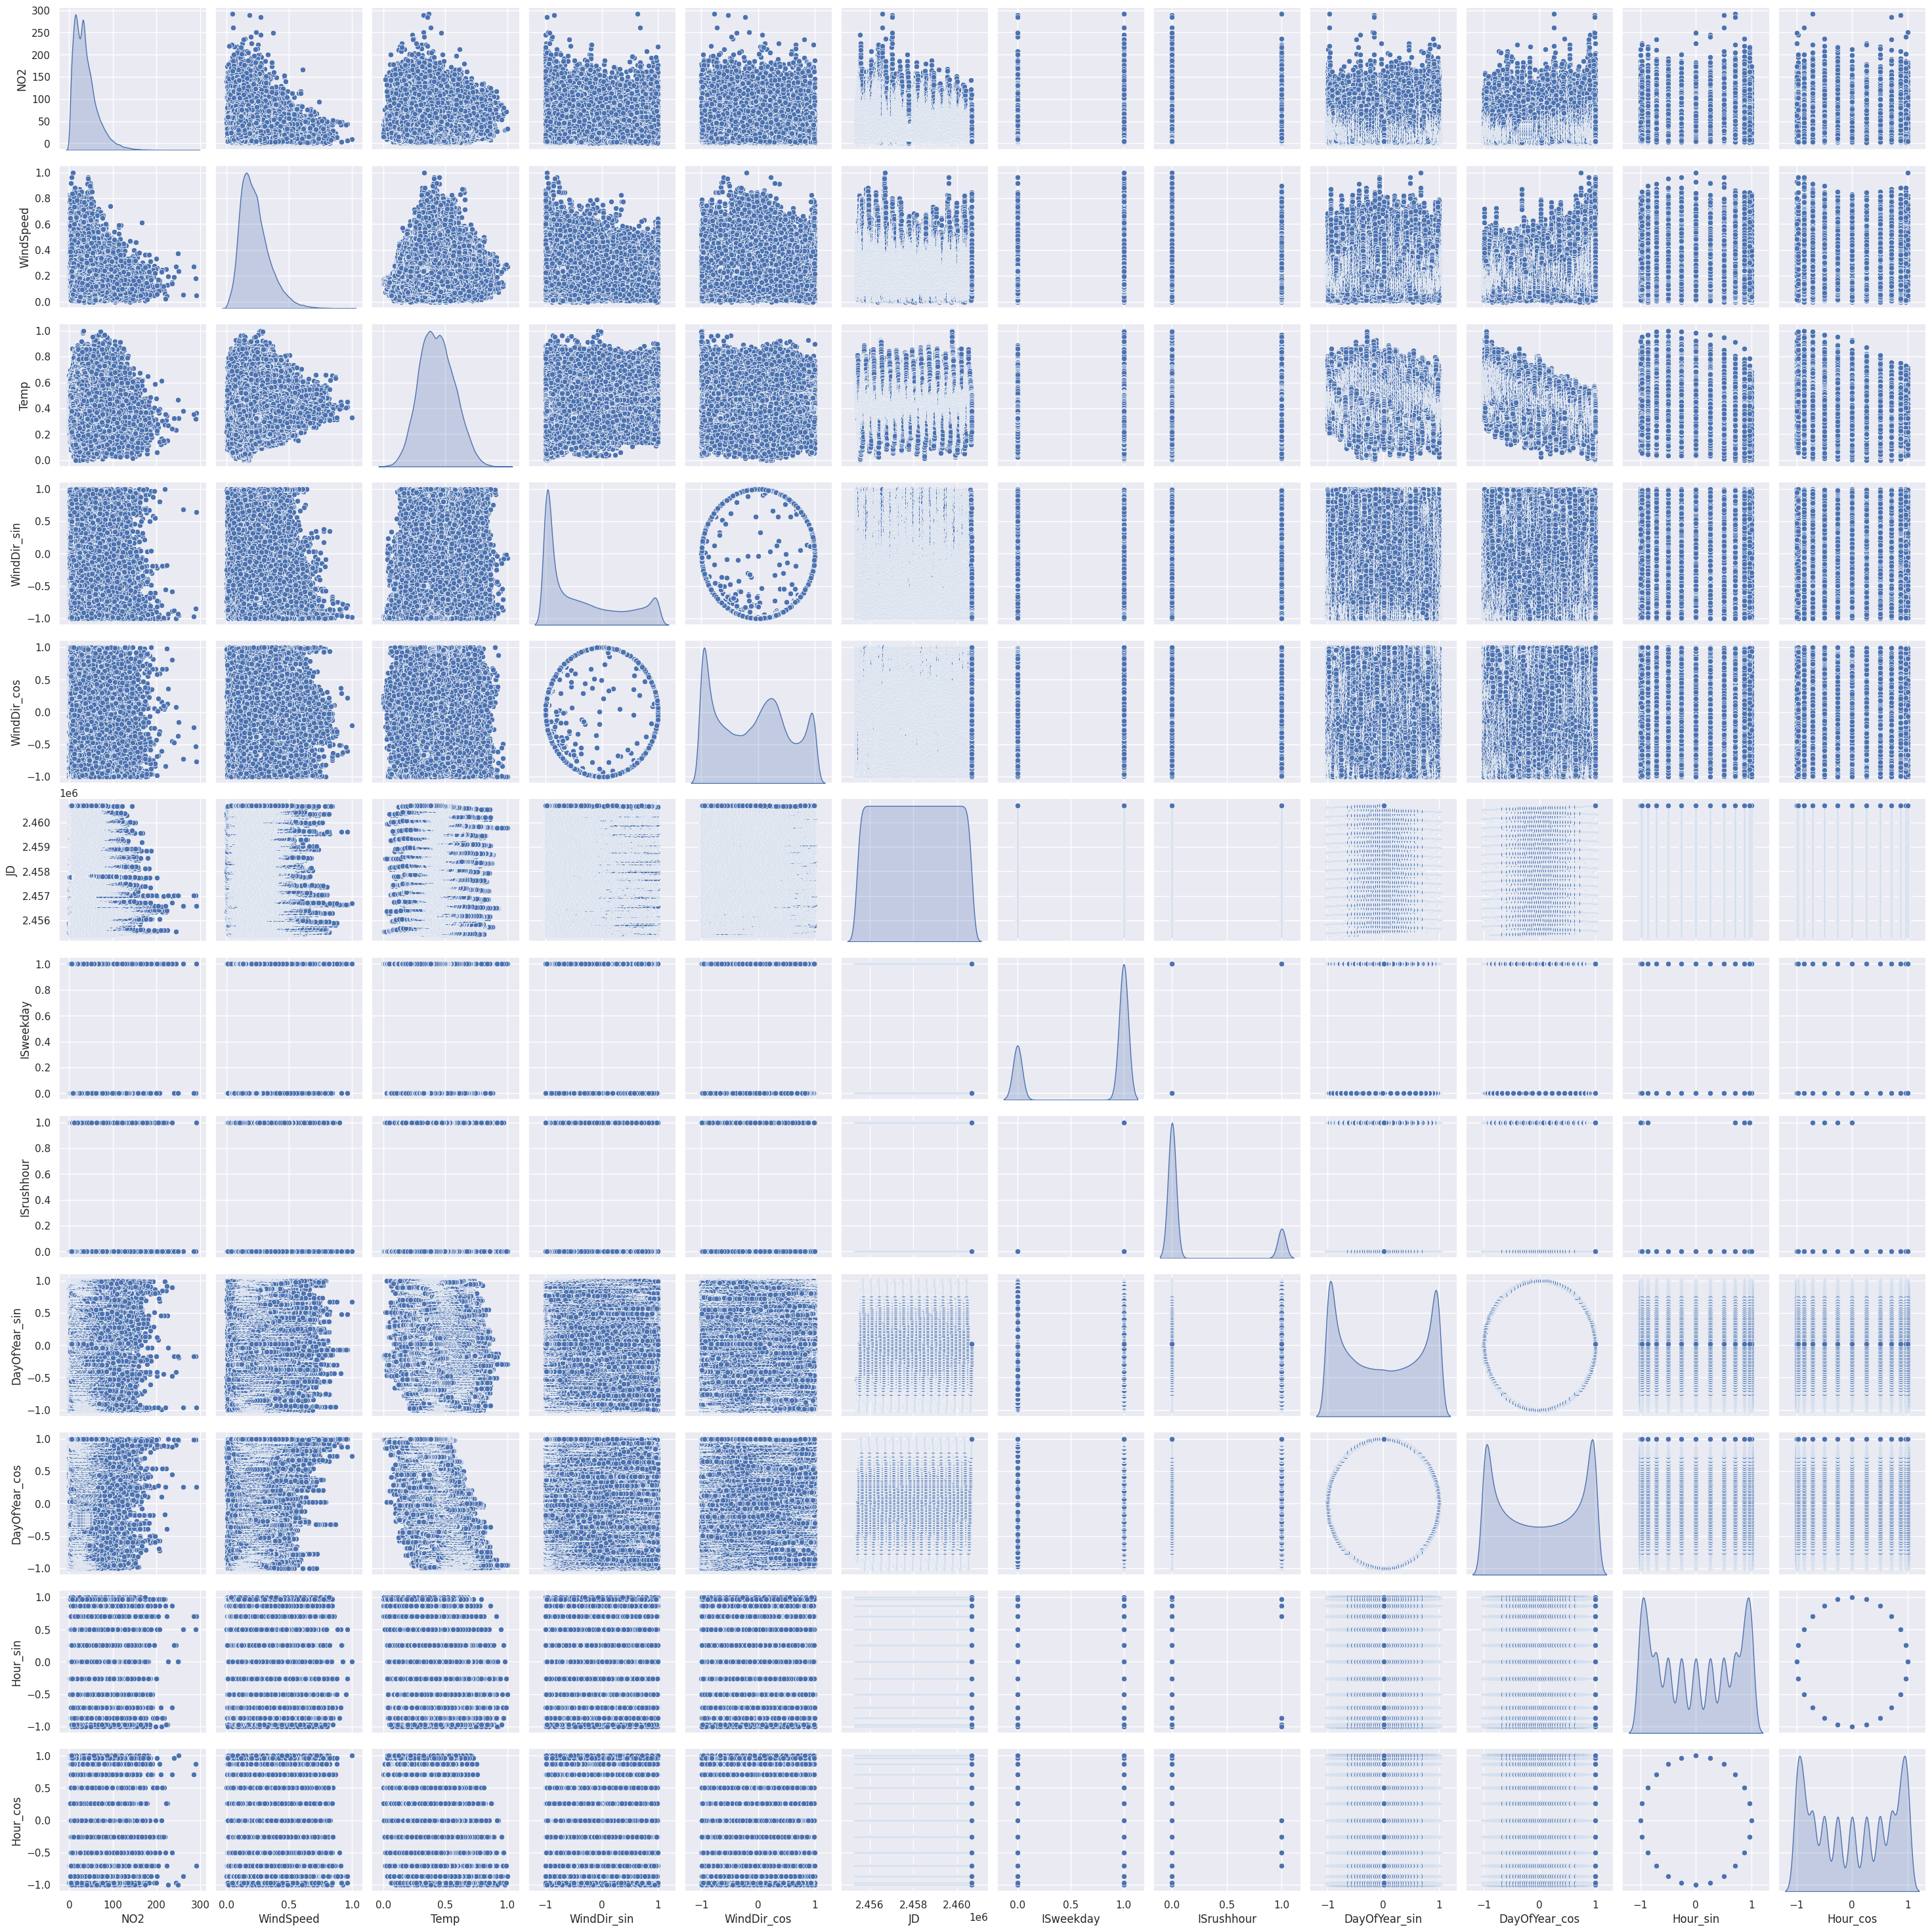

In [ ]:
# Pairplot
sns.set(rc={'figure.figsize':(10,8)})
sns.pairplot(df[[ 'NO2', 'WindSpeed', 'Temp', 'Month', 'Hour',
       'WindDir_sin', 'WindDir_cos', 'DoW', 'JD', 'DayOfYear','ISweekday',
                  'ISrushhour', 'DayOfYear_sin', 'DayOfYear_cos', 'Hour_sin',
       'Hour_cos']], diag_kind='kde')
plt.show()

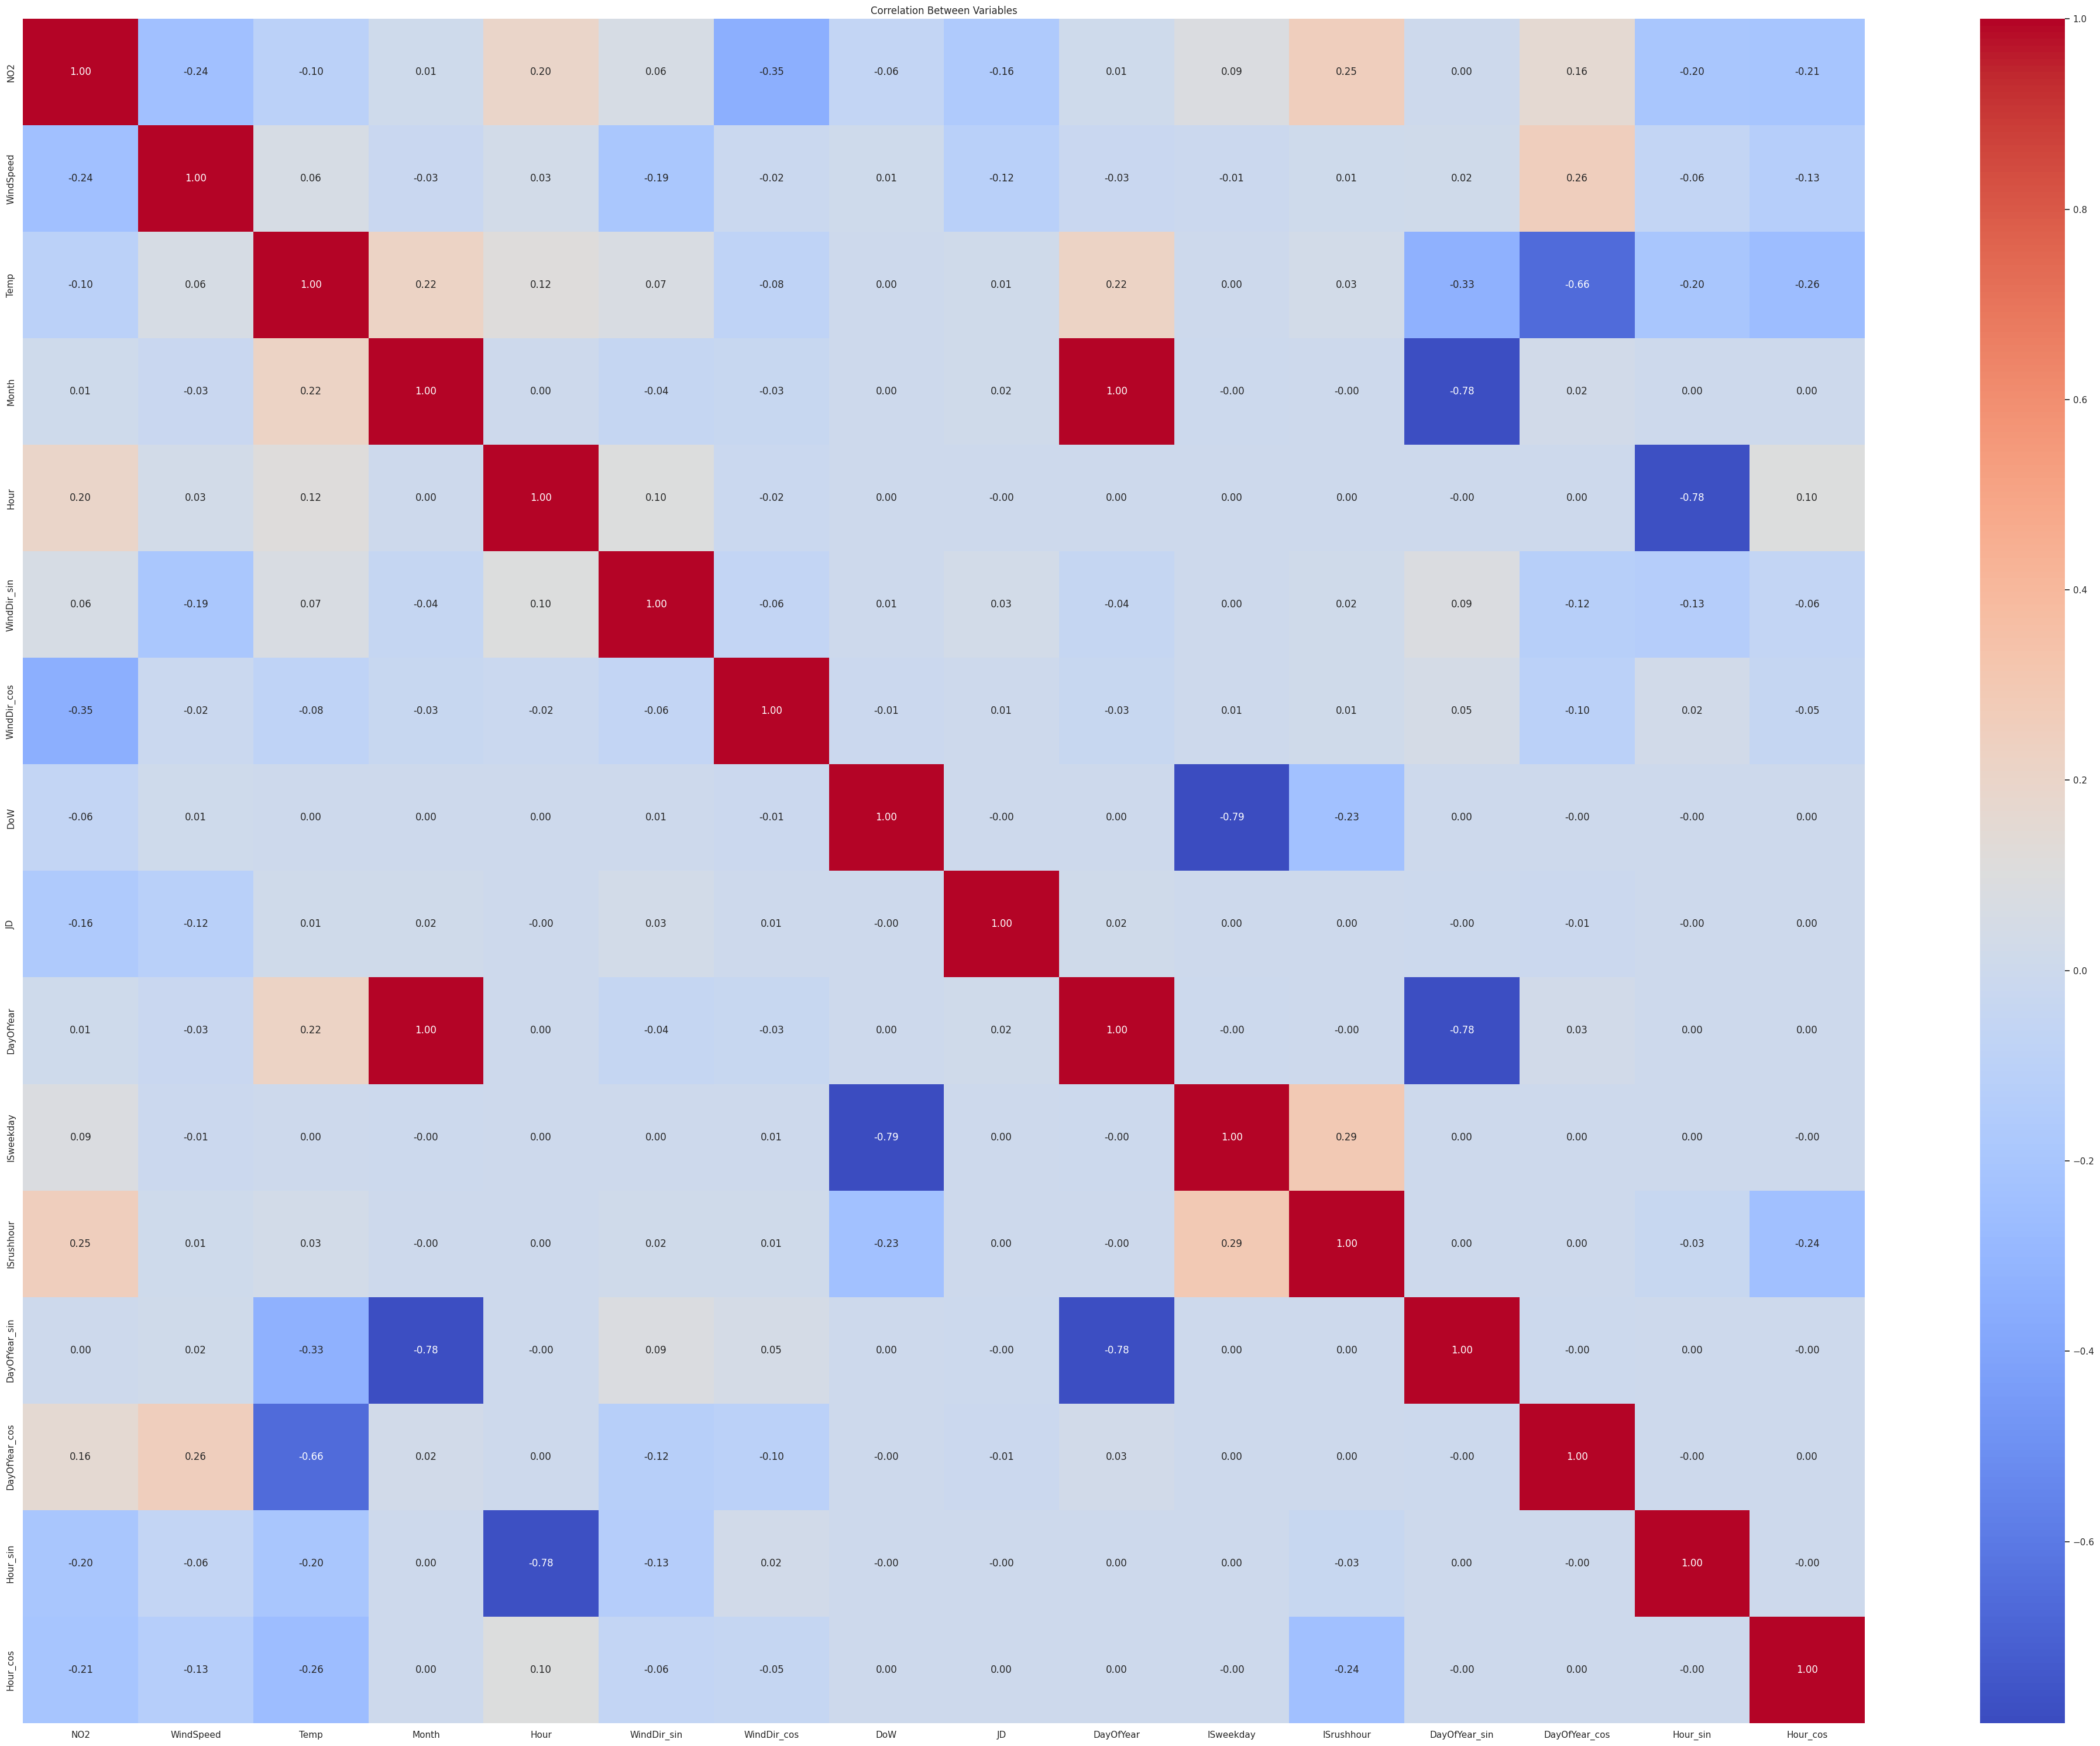

In [ ]:
plt.figure(figsize=(40, 30))
sns.heatmap(df[['NO2', 'WindSpeed', 'Temp', 'Month', 'Hour','WindDir_sin',
                'WindDir_cos', 'DoW', 'JD', 'DayOfYear', 'ISweekday',
                'ISrushhour', 'DayOfYear_sin', 'DayOfYear_cos', 'Hour_sin',
       'Hour_cos']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Variables")
plt.tight_layout()
plt.show()

# Extract training data

In [ ]:
Training = df[
    ((df['Date'] < COVID_start) | (df['Date'] >COVID_end)) &
     (df['Date'] < Start_date)] #remove covid period

#Extract Feature/ Target

In [ ]:
feature_train = Training[['WindSpeed', 'Temp', 'Month', 'Hour','WindDir_sin',
                          'WindDir_cos', 'DoW', 'JD', 'DayOfYear','ISweekday',
                          'ISrushhour', 'DayOfYear_sin', 'DayOfYear_cos',
                          'Hour_sin','Hour_cos', 'spike','isHigh']]

target_train = Training['NO2']

#The random forest


In [ ]:
rf = RandomForestRegressor(random_state=42)

## Split train

In [ ]:
feature_train, feature_validation, target_train, target_validation =(
    train_test_split(feature_train, target_train, test_size=0.2,
                     random_state=42)
)

## Optimise

Parameters

In [ ]:
# Hyperparameter distributions
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

RandomizedSearchCV

In [ ]:
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=50, cv=5, scoring='r2',
    random_state=42, n_jobs=-1, verbose=2
)

Fit

In [ ]:
random_search.fit(feature_train, target_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c108f482cf0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c108f4830b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c108f480f80>},
                   random_state=42, scoring='r2', verbose=2)

Optimised Parameters

In [ ]:
best_params = random_search.best_params_

# Print Best parameters and R²
print("Best parameters:", best_params)
print("Best CV R²:", random_search.best_score_)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 741}
Best CV R²: 0.7062600997286277


## Run Data with Optimised Parameters

In [ ]:
rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
).fit(feature_train, target_train)

In [ ]:
# # Best Parameters for Newcastle Cradlewell
# rf = RandomForestRegressor(max_depth= None, max_features= 'sqrt',
#     min_samples_leaf= 1, min_samples_split= 3, n_estimators= 741,
#                            ).fit(feature_train, target_train)

# Evaluate model

In [ ]:
target_pred = rf.predict(feature_validation)
target_pred_train = rf.predict(feature_train)

In [ ]:
  # generalisation
mse_g = mean_squared_error(target_validation, target_pred) # Mean Squared Error
r2_g = r2_score(target_validation, target_pred) # R-squared

  # Self-fit
mse_sf = mean_squared_error(target_train, target_pred_train) #Mean Squared Error
r2_sf = r2_score(target_train, target_pred_train) # R-squared

In [ ]:
# Table of model fit
modelfit_table = [
    ["Root Mean Squared Error", f'{np.sqrt(mse_g):.2f}', f'{np.sqrt(mse_sf):.2f}'],
    ["R-squared", f'{r2_g:.2f}', f'{r2_sf:.2f}'],
]

# Display
header_mf = [f'Model fitemnt at {Site}', "Generalisation", "Self Fit"]
print(tabulate(modelfit_table, headers= header_mf, tablefmt="grid"))

+-----------------------------------------+------------------+------------+
| Model fitemnt at Newcastle Cradlewell   |   Generalisation |   Self Fit |
+=========================================+==================+============+
| Root Mean Squared Error                 |            14.09 |       5.82 |
+-----------------------------------------+------------------+------------+
| R-squared                               |             0.73 |       0.95 |
+-----------------------------------------+------------------+------------+


## Run on dataset

In [ ]:
df_feature = df[['WindSpeed', 'Temp', 'Month', 'Hour','WindDir_sin',
                          'WindDir_cos', 'DoW', 'JD', 'DayOfYear','ISweekday',
                          'ISrushhour', 'DayOfYear_sin', 'DayOfYear_cos',
                          'Hour_sin','Hour_cos', 'spike','isHigh']]
ALL_predict = rf.predict(df_feature)

In [ ]:
# Calculate Residuals
Raw_residuals = df['NO2'] - ALL_predict

# **Results**
- Line Plot
- Summary Table (%change and P vaule)

## Line plot

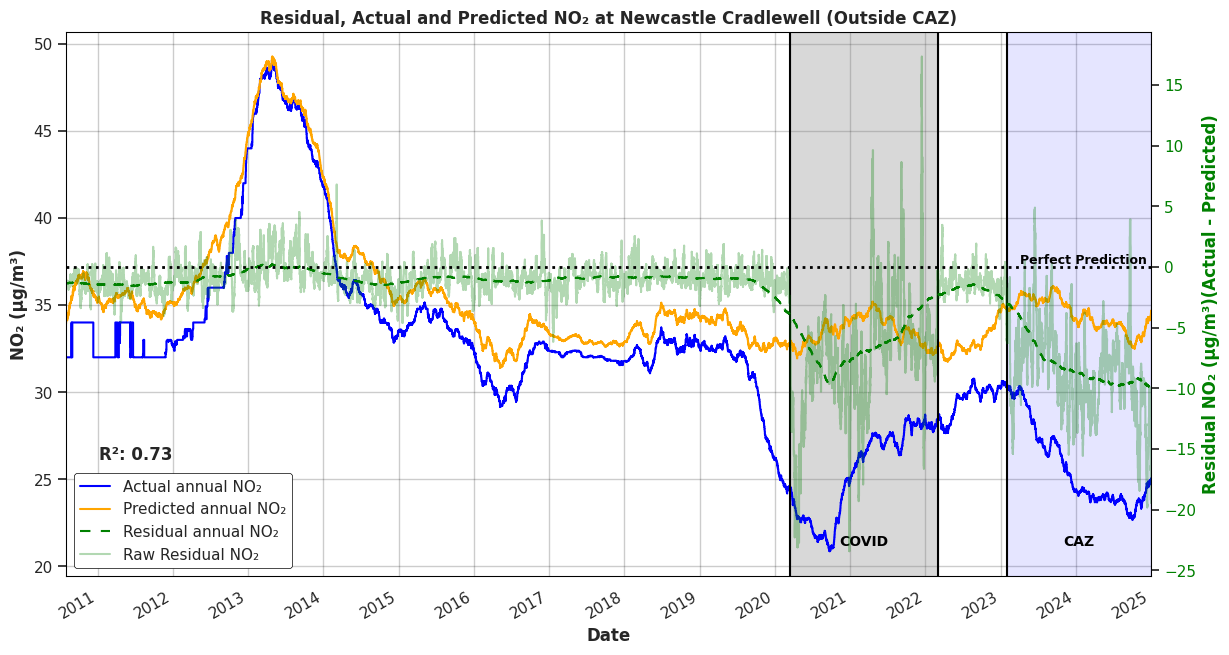

In [ ]:
# Smooth
true_365 = (
    df['NO2'].rolling(window=(24*365), center=True, min_periods=1).median())
predicted_365 = (
    pd.Series(ALL_predict).rolling(window=(24*365), center=True,
                                   min_periods=1).median())
residuals_365 = (
    Raw_residuals.rolling(window=(24*365), center=True, min_periods=1).median())
  # 7 day
residuals_7 = (
    Raw_residuals.rolling(window=(24*7), center=True, min_periods=1).median())

# Plotting
RF_plot, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

  # Actual and Predicted
true_365_line, = ax1.plot(df['Date'], true_365, color='blue',
                          linestyle='-', label='Actual annual NO₂')
predicted_365_line, = ax1.plot(df['Date'], predicted_365, color='orange',
                               linestyle='-', label='Predicted annual NO₂')

  # Residuals
residuals_365_line, = (
    ax2.plot(df['Date'], residuals_365, color='green', linestyle= (0,(5,5)),
             label='Residual annual NO₂'))
residual_daily_line, = (
    ax2.plot(df['Date'], residuals_7, color='green', alpha=0.3, linestyle='-',
             label='Raw Residual NO₂'))

  # x and y lim
ax1.set_xlim(df['Date'].min(), df['Date'].max())
# ax2.set_ylim (-15, 7)

  # Format x-axis to show ticks only at the start of each year
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
RF_plot.autofmt_xdate()

  # Perfect Prediction
ax2.axhline(y=0, color='black', linestyle=':', linewidth=2,
            label='Perfect Prediction') # 0 rediuals
x_max = ax2.get_xlim()[1]
ax2.text(x_max * 0.999, 0, 'Perfect Prediction', verticalalignment='bottom',
         horizontalalignment='right', fontsize=9, color='black', weight='bold')

#  Highlight COVID and Intervention
    # COVID
ax1.axvspan(COVID_start, COVID_end, color='gray', alpha=0.3)
x_covid_label = COVID_start + (COVID_end - COVID_start) / 2
y_covid_label = ax1.get_ylim()[0] * 1.1
ax1.text(x_covid_label, y_covid_label, 'COVID', ha='center', va='center',
         color='black', fontsize=10, weight='bold')
ax1.axvline(COVID_start, color='black', linestyle='-')
ax1.axvline(COVID_end, color='black', linestyle='-')

    # Intervention
ax1.axvspan(Start_date, df['Date'].max(), color='blue', alpha=0.1)
x_Intervention_label = Start_date + (df['Date'].max() - Start_date) / 2
y_Intervention_label = ax1.get_ylim()[0] * 1.1
ax1.text(x_Intervention_label, y_Intervention_label, f'{Intervention_type}',
         ha='center', va='center', color='black', fontsize=10, weight='bold')
ax1.axvline(Start_date, color='black', linestyle='-')

# Combine legends from both axes
lines = [true_365_line, predicted_365_line, residuals_365_line,
         residual_daily_line]
labels = [line.get_label() for line in lines]
  # Format legend
legend = ax1.legend(lines, labels, loc='lower left', frameon=True)
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_alpha(1)
frame.set_edgecolor("black")
frame.set_linewidth(.5)

#  R²
ax1.text(0.03, 0.24, f'R²: {r2_g:.2f}',transform=ax1.transAxes,
         ha='left', va='top', fontsize=12, weight='bold')

# Labels and title
ax1.set_xlabel('Date', weight='bold')
ax1.set_ylabel('NO₂ (µg/m³)', weight='bold')
ax1.set_title(
    f'Residual, Actual and Predicted NO₂ at {Site} {Extra_site_info}',
    weight='bold')
ax1.grid(True, color='black',alpha=0.2)
ax2.grid(False)
ax2.set_ylabel('Residual NO₂ (µg/m³)(Actual - Predicted)', color='green',
               weight='bold')
ax2.tick_params(axis='y', labelcolor='green')

# Format plot
  # Plot Background
ax1.set_facecolor("white")
ax2.set_facecolor("white")
    # Plot Boarder
for spine in ax1.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(.75)
for spine in ax2.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(.75)

RF_plot.show()

## Table- post intervation

In [ ]:
# Crop
Post_true = df[df['Date'] >= Start_date]
Post_predict = ALL_predict[df['Date'] >= Start_date]

# Smooth over 1 year (24 hours * 365 days)
true_365 = (
    Post_true['NO2'].rolling(window=(24*365),
                                    center=False, min_periods=1).median())
predicted_365 = (
    pd.Series(Post_predict).rolling(window=(24*365),
                                    center=False, min_periods=1).median())

# Mean
true_mean = true_365.mean()
predicted_mean = predicted_365.mean()

# Percentage change
pc = (true_mean - predicted_mean) / predicted_mean * 100

# P-value
p_value = stats.ttest_ind(true_365.dropna(),
                          predicted_365.dropna(), equal_var=False).pvalue

# Table
results_table = [
    [f'Predicted Mean (NO₂ if the {Intervention_type} was not in place)',
     round(predicted_mean, 2)],
    ["True Mean", round(true_mean, 2)],
    ["% Change", round(pc, 2)],
    ["P-value", round(p_value, 4)],
]

# Display
header = [" ", f'NO₂ at {Site} after {Intervention_type}']
print(tabulate(results_table, headers=header, tablefmt="grid"))

+--------------------------------------------------+-----------------------------------------+
|                                                  |   NO₂ at Newcastle Cradlewell after CAZ |
+==================================================+=========================================+
| Predicted Mean (NO₂ if the CAZ was not in place) |                                   34.85 |
+--------------------------------------------------+-----------------------------------------+
| True Mean                                        |                                   25.98 |
+--------------------------------------------------+-----------------------------------------+
| % Change                                         |                                  -25.44 |
+--------------------------------------------------+-----------------------------------------+
| P-value                                          |                                    0    |
+-------------------------------------------------